# PROJECT 2
**MOD510: Mandatory project 2**  
**Deadline: 14. October 2024**


Authors:  
*Dea Lana Asri*  
*Sander Øydal Sterri*  
*Urszula Maria Starowicz*  

**ABSTRACT**  
This project focuses on modeling fluid flow in a reservoir, addressing both steady-state and time-dependent solutions. The steady-state solution is derived both analytically and numerically using finite difference methods to evaluate pressure distribution under two boundary conditions: “lazy” and “not-so-lazy.” Results indicate that the “not-so-lazy” boundary condition outperforms the “lazy” condition, as its numerical solution aligns with the analytical one, while the “lazy” condition introduces errors that depend on grid size.

The project also evaluates truncation errors and compares numerical errors across different grid sizes, revealing that the error in the “lazy” solution decreases linearly with grid refinement in logarithmic scale. Numerical solutions are further assessed against the analytical [line-source solution](#russell), particularly at intermediate times, providing a quantitative evaluation of solver performance.

To enhance efficiency, different solver methods are implemented and compared based on computational time for varying grid sizes (N). Findings show that the dense method is more efficient for smaller grids (N < 90), while the sparse method becomes superior for larger grids (N $\geq$ 90).

The model is also calibrated using real well test data by adjusting key parameters such as permeability and initial pressure. Curve-fitting techniques are applied to match model predictions with observed pressure data, yielding optimized parameters: permeability (k = 261.06), initial pressure ($p_init$ = 3888.96), and outer radius ($r_e$ = 2442.90), using N = 4, time step (dt) = 0.0005, and final time (t_final) = 2.

The project’s findings provide deeper insights into reservoir flow dynamics and offer practical modeling tools for engineering applications, equipping students with the ability to analyze and model fluid flow in subsurface environments.

**Introduction**  

At the beginning of this project, we create a model of a steady-state flow case, where pressure doesn't vary over time, leading to a simplification of the governing equation to a second-order differential equation. The task involves deriving the analytical solution for pressure and implementing a numerical solution using finite difference methods, with a focus on two different boundary conditions that impact the matrix structure. We explore a "lazy" boundary condition and a "not-so-lazy" version, solving the resulting matrix equations for various grid sizes. The analytical solution reveals a linear pressure variation:

$$
p(y) = p_{\text{init}} + \alpha (y - y_e)
$$

This allows us to assess truncation errors and compare the numerical results with the analytical solution.

In the second exercise, we developed the time-dependent solution to model how pressure evolves over time by revisiting the original diffusivity equation and applying an implicit time-discretization scheme. The scheme for the interior grid point \(i\) is given by:

$$
\frac{p_i^{n+1} - p_i^n}{\Delta t} = \eta \cdot \frac{e^{-2 y_i}}{r_w^2} \cdot \frac{p_{i+1}^{n+1} + p_{i-1}^{n+1} - 2p_i^{n+1}}{\Delta y^2} \tag{14}
$$

After some transformations, we obtained the equation:

$$
-\xi_{i}p_{i+1}^{n+1} - \xi_{i} p_{i-1}^{n+1} +(1+2\xi_{i}) p_i^{n+1}=p_i^n \tag{15}
$$

The task also involves deriving the matrix equation for pressure:

$$
\begin{bmatrix}
1+\xi_{0} & -\xi_{0} & 0 & 0 \\
-\xi_{1} & 1+2\xi_{1} & -\xi_{1} & 0 \\
0 & -\xi_{2} & 1+2\xi_{2} & -\xi_{2} \\
0 & 0 & -\xi_{3} & 1+3\xi_{3}
\end{bmatrix}
\begin{bmatrix}
p_0^{n+1} \\
p_1^{n+1} \\
p_2^{n+1} \\
p_3^{n+1}
\end{bmatrix}
=
\begin{bmatrix}
p_0^n \\
p_1^n \\
p_2^n \\
p_3^n
\end{bmatrix}
+
\begin{bmatrix}
-\beta \xi_0 \\
0 \\
0 \\
2\xi_3 p_e
\end{bmatrix}
$$

This matrix equation is solved at each time step for a specific case (N = 4), implementing the solution with default input parameters. The last step involved creating a simulator to handle various input parameters and analyze the time-dependent behavior of pressure.

Next, in Exercise 3, we measured the accuracy and performance of the time-dependent numerical solver by comparing it to the analytical line-source solution, considering various pressure distributions for multiple grid sizes (N). The precision of the simulator was evaluated by plotting the results in terms of physical coordinates:

$$
p(r,t) = p_i + \frac{Q \mu}{4 \pi h k} \cdot \mathcal{W} \left(-\frac{r^2}{4\eta t}\right),
$$

where
$$
\mathcal{W}(x) = \int_{-\infty}^{x} \frac{e^u}{u} \, du.
$$

For comparison, the plots highlighted differences across various grid resolutions, allowing us to quantitatively evaluate the solver's accuracy and performance in approximating the analytical solution over time.

Lastly, we developed a numerical model of the reservoir to match real well test data, where pressure changes over time were recorded. Using a first-order finite difference approximation, we derived the formula for well pressure in terms of well block pressure through Taylor's series expansion:

$$
p_0 = p(y_w) + \frac{\Delta y}{2} \alpha,
$$

Leading to:

$$
p(y_w) = p_0 - \frac{\Delta y}{2} \alpha.
$$

We read well test data from a file and created a scatter plot of well pressures versus time. After simulating the well pressure using the numerical solver, we compared the well test data, the numerical solution, and the corresponding line-source solution. Optimizing parameters improved the match between the numerical and observed data.

Finally, based on the optimized \( r_e \), we calculated the total volume of water in the reservoir using the equation:

$$
V_{\text{water}} = \pi h (r_e^2 - r_w^2) \phi,
$$


In [1]:
#import all necessaries library
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import numba as nb
import pandas as pd

## Exercise 1: Steady State Equation
### Part 1
There is no pressure variation in time

Show that the analytical solution is $p(y) = p_{\text{init}} + \alpha (y - y_e)$

The basic equation to solve the problem is as below.

$$\frac{d^2 p}{dy^2}(y) = 0 \quad \text{for all } y \tag{1},$$

$$\frac{dp}{dy}(y = y_w) = \alpha \tag{2},$$

$$p(y = y_e) = p_{\text{init}} \tag{3},$$

First, we have to do the integration of the equation (1) with respect to $y$, which results is a constant denoted as $C_1$.

$$\frac{dp}{dy}(y) = C_1  \tag{4},$$

Then we have to integrate the equation (4) with respect to $y$, which results in another additional constant denoted as $C_2$.

$$p(y) = C_1y + C_2 \tag{5},$$

Then we have to apply the boundary conditions to find the values of $C_1$ and $C_2$. First, we apply the boundary condition (2) to find the value of $C_1$ in equation (4) hence we get the value of $C_1$ as $\alpha$. Then we apply the boundary condition (3) to find the value of $C_2$ in equation (5) as below.

\begin{align*}
p_{init} = \alpha y_e + C_2 \\
C_2 = p_{init} - \alpha y_e \tag{6},
\end{align*}

By substituting the values of $C_1$ and $C_2$ to equation (5), we get the analytical solution as below.

\begin{align*}
p(y) = \alpha y + p_{init} - \alpha y_e, \\
p(y) = p_{init} + \alpha (y - y_e) \tag{7}.
\end{align*}


### Part 2
Using the "lazy" boundary conditions that set the exterior boundary to $p_{N} = p_{e}$, and $N =4$, we can solve the equation by using the finite difference method on equation (1).

\begin{align*}
\frac{d^2 p}{dy^2} = \frac{p_{y+1} + p_{y-1} - 2p_{y}}{\Delta y^2} = 0 \\
p_{y+1} + p_{y-1} - 2p_{y} = 0 \tag{8}
\end{align*}

Evaluate equation (8) for y=0, 1, 2, and 3 with coordinate shown in the figure below.  
<div style="text-align: center;">
  <img src="Grid.png" width="400" height="300" alt="Grid Image">
  <p><em>Figure 1: Grid layout transformation. Source: Project 2 Document</em></p>
</div>


The equation (8) can be rewritten as below for each y value.
\begin{align*}
y = 0: \quad p_{1} + p_{-1} - 2p_{0} = 0 \tag{9} \\
y = 1: \quad p_{2} + p_{0} - 2p_{1} = 0 \tag{10} \\
y = 2: \quad p_{3} + p_{1} - 2p_{2} = 0 \tag{11}\\
y = 3: \quad p_{4} + p_{2} - 2p_{3} = 0 \tag{12}
\end{align*}

Considering the boundary conditions for y=0, we use forward differece to find the value of $p_{-1}$. Knowing that $\frac{dp}{dy}(y = y_w) = \alpha$ from equation (2), we can write the forward difference as below.
$$\frac{P_{0} - P_{-1}}{\Delta y} = \alpha$$  
$$P_{-1} = P_{0} - \alpha \Delta y \tag{13}$$
Substituting equation (13) to equation (9), we can rewrite the equation as below.
$$y = 0: \quad p_{1} - p_{0} = - \alpha \Delta y$$

Next, considering the boundary conditions for y =3, using the "lazy" boundary conditions where $p_{N} = p_{e}$, we can rewrite the equation (12) as below
$$y = 3: \quad p_{2} - 2p_{3} = -p_e$$

Hence, the matrix equation for the system of equations (9), (10), (11), and (12) can be written as below.
$$
\begin{bmatrix}
-1 & 1 & 0 & 0 \\
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
0 & 0 & 1 & -2
\end{bmatrix}
\begin{bmatrix}
p_0 \\
p_1 \\
p_2 \\
p_3
\end{bmatrix}
=
\begin{bmatrix}
-\alpha \Delta y \\
0 \\
0 \\
-p_e
\end{bmatrix}
$$



### Part 3
Because we're using the finite difference for second derivative to derive the matrix equation, the truncation error is then given by $\frac{h^2}{12}f^{(4)}(\xi)$, where $h$ is the grid spacing and $\xi$ is an unknown point in the interval (Section 3.4, equation 3.13 of [Hiorth, 2024](#hiorth))
As the second derivative of the equation is zero as stated in equation (1), the higher order derivative is also zero, hence the truncation error is zero.


### Part 4
The order of numerical error scales when using the lazy approximation
Using the "not-so-lazy" boundary conditions where $p_{N} = p_{e} - p_{N-1}$ where N=4 hence $p_4 = p_e - p_3$ the equation (12) can be rewritten as below.
$$y = 3: \quad p_{2} - 3p_{3} = -p_e$$
So, the matrix equation for using "not-so-lazy" boundary conditions can be written as below.
$$
\begin{bmatrix}
-1 & 1 & 0 & 0 \\
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
0 & 0 & 1 & -3
\end{bmatrix}
\begin{bmatrix}
p_0 \\
p_1 \\
p_2 \\
p_3
\end{bmatrix}
=
\begin{bmatrix}
-\alpha \Delta y \\
0 \\
0 \\
-p_e
\end{bmatrix}
$$

In [98]:
class PressureEquationSolver():
    """
    A finite difference solver to solve pressure distribution in a reservoir, 
    logarithmic grid has been used, y = ln(r/rw) The solver uses SI units internally, 
    while "practical field units" are required as input.
    Input arguments:


    
    """
    def __init__(self, n, tfinal=10, dt=0.01, rw=0.318, re=1000.0, h=11.0, phi=0.25, 
                 mu = 1.0, ct=7.8E-6, Q=1000.0, k=500, pinit=4100.0, 
                 lazy=True, solver='numpy'):
        #unit coversion factors (input unit --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24*3600
        self.bbl_to_m3_ = 0.1589873

        #Grid
        self.n_ = n
        self.rw_ = rw * self.ft_to_m_
        self.re_ = re * self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        #Rock and Fluid Properties
        self.k_ = k*1E-15 / 1.01325 #from Darcy to m^2
        self.phi_ = phi
        self.mu_ = mu*1E-3 #from cp to Pas
        self.ct_ = ct / self.psi_to_pa_
        

        #Time control for simulation
        self.dt_ = dt*self.day_to_sec_
        self.t_final = tfinal*self.day_to_sec_ # final time in seconds
        self.current_time = 0.0 # current time
        self.time = [] # time vector

        #Grid generation
        self.ye_ = np.log(self.re_/self.rw_)
        self.dy_ = self.ye_/self.n_
        self.ya_ = np.linspace(0, self.ye_, 100) #for plotting analytical solution
        self.yn_ = np.arange(self.dy_/2, self.ye_, self.dy_)
        self.r_ = np.linspace(0, self.re_, 100) #for plotting line source solution
        self.r_values_ = self.rw_ * np.exp(self.yn_)

        #Initial and Boundary Conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pinit_ = pinit*self.psi_to_pa_
        self.alpha_ = self.Q_*self.mu_/(2*np.pi*self.k_*self.h_)
        self.beta_ = self.Q_*self.mu_*self.dy_/(2*np.pi*self.k_*self.h_)
        self.lazy_ = lazy
        
        #Initiate value
        self.xi = self.k_*np.exp(-2*self.yn_)*self.dt_/(self.mu_*self.phi_*self.ct_*self.rw_**2*self.dy_**2)
        self.eta_ = self.k_/(self.mu_*self.ct_*self.phi_)
        self.A = np.array([])
        self.rhs = np.array([])
        self.p = np.array([])
        self.pinit = np.repeat(self.pinit_, self.n_)
        self.pt = np.array([]) #pressure solution through time
        self.solver_ = solver
        self.a_, self.b_, self.c_ = (np.zeros(self.n_) for _ in range(3))

    def set_up_matrix_ss(self):
        """ Set up matrix for steady state solution
        Return:
        A: array, matrix for steady state solution"""
        a = np.ones(self.n_-1)
        b = -2*np.ones(self.n_)
        c = np.ones(self.n_-1)

        b[0] = -1

        if self.lazy_==False:
            b[-1] = -3

        #Create the matrix
        self.A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
        return self.A
    
    def set_up_matrix_td(self ):
        '''Set up matrix for time dependant solution
        Return:
        A: array, matrix for time dependant solution'''
        #initiate value of matrix a, b, c
        for i in range(self.n_):
            self.a_[i] = -self.xi[i]
            self.b_[i] = (1+2*self.xi[i])
            self.c_[i] = -self.xi[i]
            #modifying value of b for certain i
            if i==0:
                self.b_[i] = (1+self.xi[i])
            if i==self.n_-1:
                self.b_[i] = (1+3*self.xi[i])
        
        #create the matrix
        if self.solver_ == 'numpy':
            self.A = np.diag(self.a_[1:],-1) + np.diag(self.b_,0) + np.diag(self.c_[:-1],1)
        elif self.solver_ == 'sparse':
            data=np.zeros((3,self.n_))
            data[0,:-1]= self.a_[1:]
            data[1,:]  = self.b_
            data[2,1:] = self.c_[:-1]
            diagonals = [-1,0,1]
            self.A = sp.sparse.spdiags(data, diagonals, self.n_, self.n_, format='csc')
            
        return self.A


    def set_up_rhs_ss(self, simpleAlpha = True):
        """ Set up right hand side for steady state solution
         parameters:
         simpleAlpha: boolean (default=True), when True, alpha = 1
         """
        if simpleAlpha:
            self.alpha_ = 1
        self.rhs = np.zeros(self.n_)
        self.rhs[0] = self.alpha_*self.dy_
        if self.lazy_:
            self.rhs[-1] = -self.pinit_
        else:
            self.rhs[-1] = -2*self.pinit_ 

    def set_up_rhs_td(self, pold):
        '''Set up right hand side for time dependant solution
        parameters:
        pold: array, pressure at previous time step (Pa)'''
        self.rhs = pold + np.zeros(self.n_)
        self.rhs[0] = self.rhs[0] - self.beta_*self.xi[0]
        self.rhs[-1] = self.rhs[-1] + 2*self.xi[-1]*self.pinit_
        return self.rhs
        
    def solve_ss(self):
        """ Solve the steady state solution """
        self.set_up_matrix_ss()
        self.set_up_rhs_ss()
        self.p = np.linalg.solve(self.A, self.rhs)

    def solve_td(self):
        """ Solve the time dependent solution """
        self.set_up_matrix_td()
        pold = self.pinit
        self.pt = pold
        self.current_time = self.dt_
        self.time.append(self.current_time)
        while self.current_time <= self.t_final:
            self.set_up_rhs_td(pold)
            if self.solver_ == 'numpy':
                pnew = np.linalg.solve(self.A, self.rhs)
            elif self.solver_ == 'sparse':
                pnew = sp.sparse.linalg.spsolve(self.A, self.rhs)
            else:
                #raise error if solver not implemented
                raise ValueError('Solver not implemented. Choose numpy or sparse')
            self.pt = np.append(self.pt, pnew)
            pold = pnew
            self.current_time += self.dt_
            if self.current_time <= self.t_final:
                self.time.append(self.current_time)
        

    def analytical_solution (self,y,simpleAlpha = True):
        '''Calculate the analytical solution
        Parameters:
        y: float
        simpleAlpha: boolean (default=True), when True, alpha = 1

        Return:
        py: array, analytical solution for pressure distribution (Pa)
        '''
        if simpleAlpha:
            self.alpha_ = 1
        py = self.pinit_ + self.alpha_ * (y-self.ye_)
        return py


    def calculate_error(self):
        '''Calculate the error between numerical and analytical solution
        Return:
        error: array, error between numerical and analytical solution
        '''
        error = np.abs(self.p - self.analytical_solution(self.yn_))
        return np.round(error,2)
    
    def plot(self, td=False):
        '''Plot the numerical and analytical solution
        parameters:
        td: boolean (default=False), when True, plot time dependent solution'''
        fig, ax = plt.subplots()
        #Define colors
        colors = ['r', 'g', 'b', 'c', 'm']
        if td==True:
            for i in range(len(self.time)):
                ax.scatter(self.yn_, self.pt[(i+1)*self.n_:(i+2)*self.n_], color=colors[i % len(colors)], marker='*', label = f't = {np.round(self.time[i]/self.day_to_sec_,3)} days')
            ax.plot(self.ya_, self.analytical_solution(self.ya_, simpleAlpha=False), 'b-', label='Analytical')
        else:
            ax.plot(self.yn_, self.p, 'r*', label='Numerical')
            ax.plot(self.ya_, self.analytical_solution(self.ya_), 'b-', label='Analytical')
        ax.legend()
        ax.set_title(f'Pressure distribution; Boundary condition: Lazy = {self.lazy_}')
        ax.set_xlabel('y')
        ax.set_ylabel('Pressure (Pa)')
        ax.grid()
        plt.show()
    
    def line_source_well(self, r, t):
        '''Calculate pressure distribution for line source solution at certain r and t
        Parameters:
        r: float, distance from wellbore (m)
        t: float, time (s)
        
        Return:
        p_line_source: float, pressure distribution for line source solution (Pa)
        '''
        p_line_source = self.pinit_ + self.alpha_/2 * sp.special.expi(-(r**2/(4*self.eta_*t)))
        return p_line_source
    
    def cal_well_pressure(self):
        '''Calculate the well pressure in terms of well block pressure using first-order finite difference approximation
        Return:
        pwell: array, well pressure (psi)
        timepwell: array, time (minutes)'''
        self.solve_td()
       
        #Initiate value
        pwell = np.zeros(len(self.time))
        timepwell = np.zeros(len(self.time))

        #calculate wellpressure (psi) for each time step (minutes)
        for i in range(len(self.time)):
            pwell [i] = (self.pt[(i+1)*self.n_] - self.dy_*(self.Q_*self.mu_/(2*np.pi*self.k_*self.h_)/2))/self.psi_to_pa_
            timepwell [i] = self.time[i]/60
        return pwell, timepwell
    


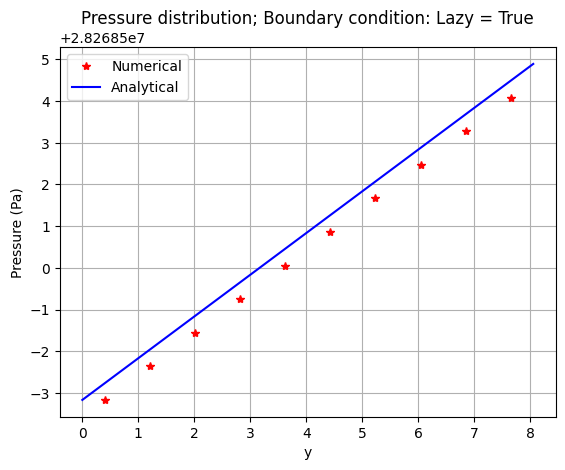

In [99]:
n=10
pressure = PressureEquationSolver(n)
pressure.solve_ss()
pressure.plot()

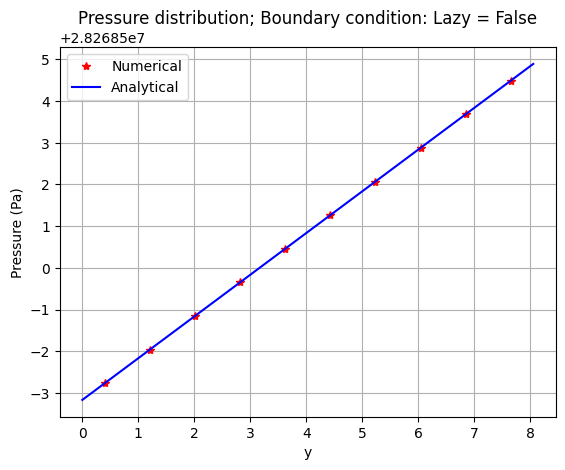

In [100]:
b = PressureEquationSolver(n, lazy=False)
b.solve_ss()
b.calculate_error()
b.plot()

From the implementation of 'lazy' and 'not-so-lazy' solution above, we can see that the numerical solution for the 'not-so-lazy' is exactly the same as analytical solution. While the 'lazy' solution has error that scales with the grid size. Hence the 'not-so-lazy' solution is better than the 'lazy' solution for this application where the nodes is in between the grids.

### Part 5
The error for both implementation of boundary conditions in regards to the numbers of grid points is plotted in the following graph.


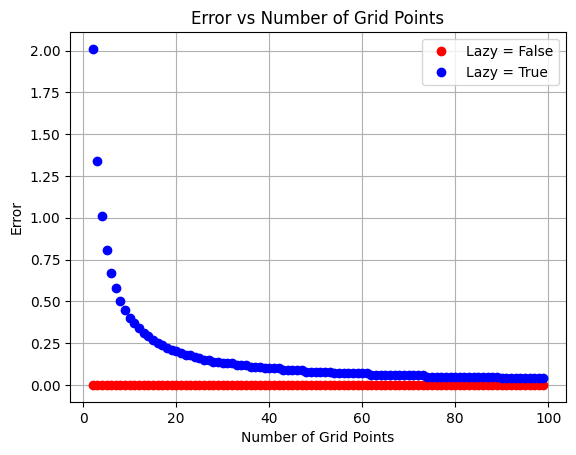

In [5]:
#Calculate error for different grid size
n = np.arange(2, 100, 1)
lazy_mode = [False, True]
error = np.zeros(len(n)*len(lazy_mode)).reshape(len(lazy_mode), len(n))
for idx1, i in enumerate (lazy_mode):
    for idx2, j in enumerate (n):
        pressure = PressureEquationSolver(j, lazy=i)
        pressure.solve_ss()
        #take 1 error value since it is the same at all point
        error[idx1, idx2] = pressure.calculate_error()[-1]
#plot error vs grid size
fig, ax = plt.subplots()
#grid_sizes = 
ax.plot(n, error[0,:], 'ro', label='Lazy = False')
ax.plot(n, error[1,:], 'bo', label='Lazy = True')
ax.legend()
ax.set_title('Error vs Number of Grid Points')
ax.set_xlabel('Number of Grid Points')
ax.set_ylabel('Error')
ax.grid(True)

It is shown from the figure above that with the 'lazy' solution the error is decreasing with number of grid points. Whereas with the 'not-so-lazy' solution the error is always zero for all number of grid points. This is happens because for 'not-so-lazy' solution the error is small enought to be close to zero even with low number of grid points. On the other hand, 'lazy' solution is becoming more accutare.

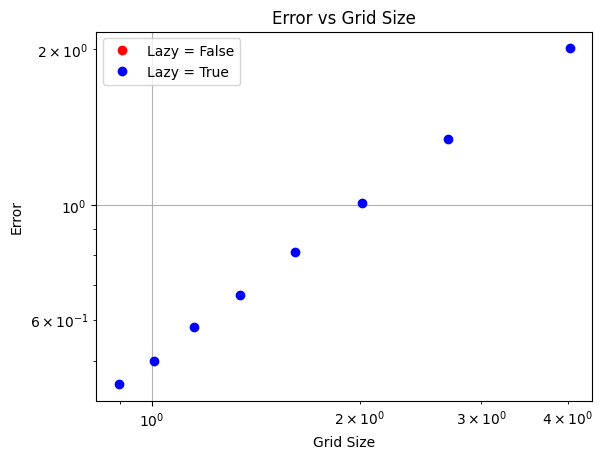

In [94]:
#Calculate error for different grid size
n = np.arange(2, 10, 1)
lazy_mode = [False, True]
error = np.zeros(len(n)*len(lazy_mode)).reshape(len(lazy_mode), len(n))
dy = np.array([])
for idx1, i in enumerate (lazy_mode):
    for idx2, j in enumerate (n):
        pressure = PressureEquationSolver(j, lazy=i)
        pressure.solve_ss()
        #take 1 error value since it is the same at all point
        error[idx1, idx2] = pressure.calculate_error()[-1]
        dy = np.append(dy, pressure.dy_)
#plot error vs grid size
fig, ax = plt.subplots()
#modifying dy value
dy = dy[:int(len(dy)/2)]
ax.plot(dy, error[0,:], 'ro', label='Lazy = False') #When set to the logaritmic scale, the error is not visible because the error is 0
ax.plot(dy, error[1,:], 'bo', label='Lazy = True')
ax.legend()
ax.set_title('Error vs Grid Size')
ax.set_xlabel('Grid Size')
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)


As we see before that in 'Error vs Number of Grid Points' plot, the error in non linear whereas if we look at the plot of error vs grid size in logarithmic scale, we can see that the error for the 'lazy solution' is linearly decreasing as the grid size decrease following the power law. 

Meanwhile, the error for the 'not-so-lazy solution' is constant and equal to zero for all grid sizes hence we can not really see it in the log-log plot above.

## Exercise 2: Time Dependant Solution
### Part 1

Implicit scheme for interior grid point $i$ is given by the equation below.
$$\frac{p_i^{n+1} - p_i^n}{\Delta t} = \eta \cdot \frac{e^{-2 y_i}}{r_w^2} \cdot \frac{p_{i+1}^{n+1} + p_{i-1}^{n+1} - 2p_i^{n+1}}{\Delta y^2} \tag{14}$$
given that $\xi_{i} = \eta \frac{e^{-2 y_i} \Delta t}{r_w^2 \Delta y^2}$, equation (14) can be rewritten as below.
$$-\xi_{i}p_{i+1}^{n+1} - \xi_{i} p_{i-1}^{n+1} +(1+2\xi_{i}) p_i^{n+1}=p_i^n\tag{15}$$
For N=4, the equation (15) is evaluated for i=1, 2, and 3 as below.
\begin{align*}
i = 0: \quad -\xi_{0}p_{1}^{n+1} -\xi_{0} p_{-1} + (1+2\xi_{0}) p_0^{n+1} = p_0^n \tag{16} \\
i = 1: \quad -\xi_{1}p_{2}^{n+1} -\xi_{1} p_{0} + (1+2\xi_{1}) p_1^{n+1} = p_1^n \tag{17} \\
i = 2: \quad -\xi_{2}p_{3}^{n+1} -\xi_{2} p_{1} + (1+2\xi_{2}) p_2^{n+1} = p_2^n \tag{18} \\
i = 3: \quad -\xi_{3}p_{4}^{n+1} -\xi_{3} p_{2} + (1+2\xi_{3}) p_3^{n+1} = p_3^n \tag{19}
\end{align*}
Considering the boundary conditions for i=0,
$$\frac{dp}{dy}= \frac{Q \mu}{2 \pi h k}$$
$$\frac{p_0^{n+1} - p_{-1}^{n+1}}{\Delta y} = \frac{Q \mu}{2 \pi h k}$$
$$p_{-1}^{n+1} = p_0^{n+1} - \beta, \tag{20}$$
where $\beta = \frac{Q \mu \Delta y}{2 \pi h k}$.

So, the equation (16) can be rewritten as below.
$$-\xi_{0}p_{1}^{n+1} -\xi_{0} p_{1}^{n+1} + (1+\xi_{0}) p_0^{n+1} = p_0^n - \beta \xi_0$$

Next, considering the boundary conditions for i=3, where $p_4 = 2p_e - p_3$, the equation (19) can be rewritten as below.
$$-\xi_{3}p_{2}^{n+1} + (1+3\xi_{3}) p_3^{n+1} = p_3^n + 2\xi_3 p_e$$

Using equation (16), (17), (18), and (19), the matrix equation for the system of equations can be written as below.
$$
\begin{bmatrix}
1+\xi_{0} & -\xi_{0} & 0 & 0 \\
-\xi_{1} & 1+2\xi_{1} & -\xi_{1} & 0 \\
0 & -\xi_{2} & 1+2\xi_{2} & -\xi_{2} \\
0 & 0 & -\xi_{3} & 1+3\xi_{3}
\end{bmatrix}
\begin{bmatrix}
p_0^{n+1} \\
p_1^{n+1} \\
p_2^{n+1} \\
p_3^{n+1}
\end{bmatrix}
=
\begin{bmatrix}
p_0^n \\
p_1^n \\
p_2^n \\
p_3^n
\end{bmatrix}
+
\begin{bmatrix}
-\beta \xi_0 \\
0 \\
0 \\
2\xi_3 p_e
\end{bmatrix}





### Part 2
Assuming default model input parameters, N=4 and $\Delta t = 0.01 day$, the value of matrix equation above is calculated as below.


In [50]:
pressure = PressureEquationSolver(4, dt=0.01, lazy=False)
td_matrix = pressure.set_up_matrix_td()
print(td_matrix)

[[ 5.28702460e+03 -5.28602460e+03  0.00000000e+00  0.00000000e+00]
 [-9.42633218e+01  1.89526644e+02 -9.42633218e+01  0.00000000e+00]
 [ 0.00000000e+00 -1.68095582e+00  4.36191165e+00 -1.68095582e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.99757363e-02  1.08992721e+00]]


### Part 3
Implement a simulator that solves the equation for the time-dependent solution.

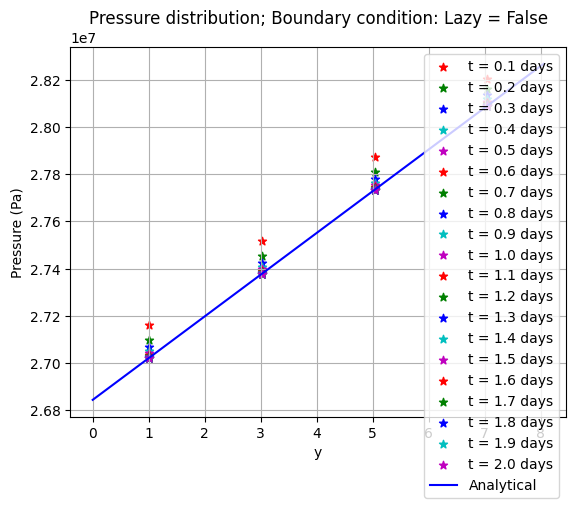

In [101]:
time_dependant = PressureEquationSolver(n=4, tfinal=2, dt=0.1, lazy=False)
time_dependant.solve_td()
time_dependant.plot(td=True)

From the figure above, we could see that as the time step increasing, the pressure of the time dependant equation is getting closer to the steady state solution (blue line, analytical solution). 

## Exercise 3: Accuracy and Performance of time-dependent solution
### Part 1
For several values of N, compare the numerical solver implementation to the line-source solution below.
$$p(r,t) = p_i + \frac{Q \mu}{4 \pi h k} \cdot {W} (-\frac {r^2}{4\eta t})$$
where $\mathcal{W}(x) = \int_{-\infty}^{x} \frac{e^u}{u} \, du$. To do the comparison, solution should be plotted in terms of physical coordinates, $r(y) = r_w e^y$.



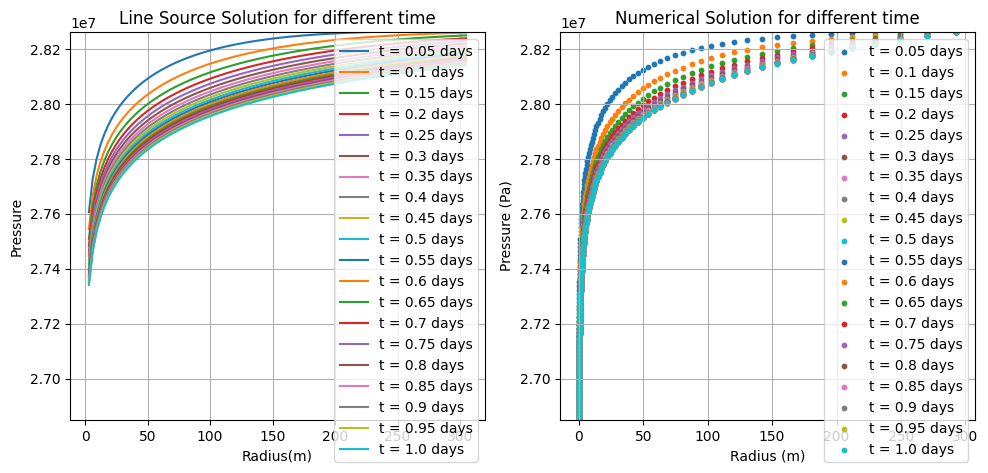

In [86]:
line = PressureEquationSolver(100, dt=0.05, tfinal=1, lazy=False)
#plot line source solution for different t
line.solve_td()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for i in range(len(line.time)):
    line_sol = line.line_source_well(line.r_, line.time[i])
    ax1.plot(line.r_, line_sol, label=f't = {np.round(line.time[i]/line.day_to_sec_,3)} days')
    ax1.legend()
ax1.set_title('Line Source Solution for different time')
ax1.set_xlabel('Radius(m)')
ax1.set_ylabel('Pressure')
ax1.grid()

#plot numerical solution for different t
for i in range(len(line.time)):
    ax2.scatter(line.r_values_, line.pt[(i+1)*line.n_:(i+2)*line.n_], label=f't = {np.round(line.time[i]/line.day_to_sec_,3)} days', s=10)
    ax2.legend()
    y2 = np.array(line.pt[(i+1)*line.n_:(i+2)*line.n_])
ax2.set_title('Numerical Solution for different time')
ax2.set_xlabel('Radius (m)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid()

# Set the same y-axis limits for both subplots
y_min = y2.min()
y_max = y2.max()
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Since the line-source solution is only valid at intermediate times, when reservoir boundary eﬀects are negligible and looking at the range from 2 figures above, we will compare the numerical solution with line source solution for approximtely $t \leq 0.2$ days. Then we will plot  Line source solution and numerical solution for $t \leq 0.2$ days with specified N values.

Text(0.5, 1.0, 'Line Source vs Numerical Solution')

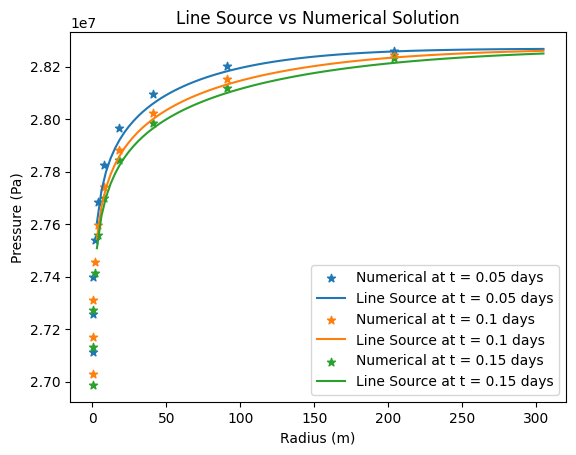

In [105]:
#compare line source solution and numerical solution for t <= 0.2 days
fig, ax = plt.subplots()
n=10
colors = ['r', 'g', 'b', 'c', 'm']
i = 0

line = PressureEquationSolver(n, dt=0.05, tfinal=0.5, lazy=False)
line.solve_td()

# Iterate while t <= 0.2 days
while line.time[i] / line.day_to_sec_ < 0.2:
    line_sol = line.line_source_well(line.r_, line.time[i])
    ax.scatter(line.r_values_, line.pt[(i+1)*line.n_:(i+2)*line.n_], marker='*', label=f'Numerical at t = {np.round(line.time[i]/line.day_to_sec_,3)} days')
    ax.plot(line.r_, line_sol, label=f'Line Source at t = {np.round(line.time[i]/line.day_to_sec_,3)} days')
    i += 1  # Update the time index

    
ax.legend()
ax.set_xlabel('Radius (m)')
ax.set_ylabel('Pressure (Pa)')
ax.set_title('Line Source vs Numerical Solution')

### Part 2


In [91]:
#Dense Method
n = np.arange(10, 160, 20)
for i in n:
    #dense Method
    dense = PressureEquationSolver(i, lazy=False, solver='numpy')
    dense.solve_td()

    #Sparse Method
    sparse = PressureEquationSolver(i, lazy=False, solver='sparse')
    solution_sparse = sparse.solve_td()

    print(f'N = {i}')
    %timeit dense.solve_td()
    %timeit sparse.solve_td()


N = 10
11 ms ± 207 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.7 ms ± 530 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 30
21.1 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40 ms ± 79.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 50
32.4 ms ± 355 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.2 ms ± 920 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 70
49.7 ms ± 295 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
57.1 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 90
64.1 ms ± 560 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.7 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 110
88.1 ms ± 907 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
69.7 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
N = 130
120 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
78.3 ms ± 1.93 ms per loop (mean ± st

The efficiency is evaluated based on the time it takes to solve the problem for different values of N. The results are shown in the table below.

<div style="text-align: center;">
  <p><em>Table 1: Comparison of Executed time between Dense and Sparse Method</em></p>
  <img src="TableTime.png" width="600" height="300" alt="Grid Image">
</div>




Based on the results above, it is shown that dense method is more efficient for smaller values of N, while sparse method is more efficient for larger values of N. In this case, sparse method is more efficient for $N \geq 90$.

## Exercise 4: Match model to well test data
### Part 1
Calculate pressure distribution inside the reservoir by discretizing equation (2)

Use a first-order finite difference approximation to find formula for the well pressure in terms of well block pressure, $p_0$. Using Taylor's series expansion with $\Delta h = \frac{\Delta y} {2}$, we can write the pressure at the well block as below.
$$p_0 = p(y_w + \frac {\Delta y}{2}) = p(y_w)+p'(y_w)\frac {\Delta y}{2}+\frac{1}{2}p''(y_w)\frac{\Delta y^2}{4}+... \tag{21}$$
Truncating the series at the first order and substitute the first order series with equation (2), we get the formula for the well pressure as below.
$$p_0 = p(y_w) + \frac{\Delta y}{2} \alpha \tag{22}$$
Hence,
$$p(y_w) = p_0 - \frac{\Delta y}{2} \alpha \tag{23}$$




### Part 2
Read the well test data into python and make a scatter plot of well pressures versus time.

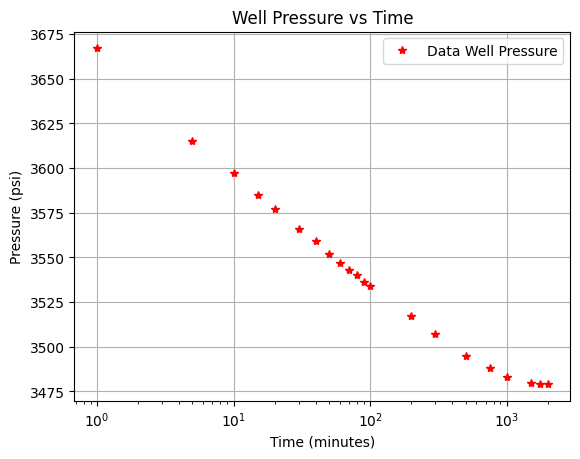

In [106]:
#Read well data from file
well_data = pd.read_csv('data/well_bhp.dat', sep='\t')

#Plot well pressure vs time
fig, ax = plt.subplots()
ax.plot(well_data['time'], well_data['well_pressure'], 'r*', label='Data Well Pressure')
ax.set_title('Well Pressure vs Time')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Pressure (psi)')
ax.set_xscale('log')
ax.legend()
ax.grid()

### Part 3
Towards the end of the test, we see that the well pressure stabilizes towards a constant value. This indicates that the pressure wave has reached theedge of the reservoir.
For this part you may assume default model input for all parameters except the following three: $k, p_i$, and $r_e$.

Make a plot in which you compare 1) the well test data, 2) your numerical well pressure solution, and 3) the corresponding line-source solution.

To find the optimal values of $k, p_i$, and $r_e$, we can fit the numerical well pressure solution to the well test data. The optimal values of $k, p_i$, and $r_e$ are found by minimizing the sum of squared errors between the numerical well pressure solution and the well test data. To do so, we can use the curve_fit function from the scipy.optimize module. Referring to the documentation of curve_fit [(Documentation of curve_fit)](#curvefit), this function works by adjusting the parameters of a predefined mathematical function to best match a set of data points. To use this, we have to provide the function, the data, and initial guesses for the parameters. The algorithm then iteratively updates the parameters to reduce the difference between the data and the model until it finds the optimal fit, producing the best set of parameters for the function.

In this particular case, we also use interpolated value of the numerical solution to match the time of the well test data. The algorithm 

The optimized value of k, pinit, and re are [ 261.06442014 3888.95986048 2442.89926657] respectively


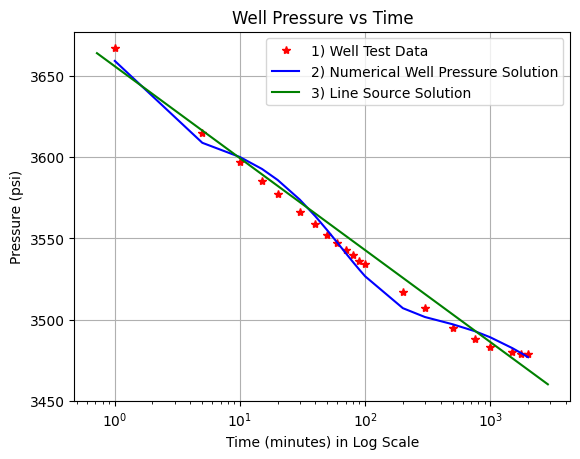

In [90]:
well_data = pd.read_csv('data/well_bhp.dat', sep='\t')

#Define fitting function
def fitting_function(time, k, pinit, re):
    solver = PressureEquationSolver(4, dt=0.0005, tfinal=2, k=k, pinit=pinit, re=re, lazy=False)
    pwell, timepwell = solver.cal_well_pressure()
    #return the interpolated value of well pressure
    return np.interp(time, timepwell, pwell)

popt, pcov = sp.optimize.curve_fit(fitting_function, well_data['time'], well_data['well_pressure'], p0=[500, 4100, 1000])
print(f'The optimized value of k, pinit, and re are {popt} respectively')

solver = PressureEquationSolver(4, dt=0.0005, tfinal=2, k=popt[0], pinit=popt[1], re=popt[2], lazy=False)
solver.solve_td()

#create array to store the value of line source solution at r=0
line_source = np.zeros(len(solver.time))
time_min = np.zeros(len(solver.time))

#Calculate line source solution at r=rw for each time step
for i in range(len(solver.time)):
    time_min[i] = solver.time[i]/60
    line_source[i] = (solver.line_source_well(solver.rw_, solver.time[i]))/solver.psi_to_pa_

#Plot the well pressure data, numerical well pressure solution, and line source solution
fig, ax = plt.subplots()
ax.plot(well_data['time'], well_data['well_pressure'], 'r*', label='1) Well Test Data')
ax.plot(well_data['time'], fitting_function(well_data['time'], *popt), 'b-', label='2) Numerical Well Pressure Solution')    
ax.plot(time_min, line_source, 'g-', label='3) Line Source Solution')
ax.set_title('Well Pressure vs Time')
ax.set_xlabel('Time (minutes) in Log Scale')
ax.set_ylabel('Pressure (psi)')
ax.set_xscale('log')
ax.legend()
ax.grid()

#Save the plot
fig.savefig('well_pressure.png')


As the first data in the well test data is at time 1 minutes $\approx 0.000694$, we could use $dt \leq 0.000694$ and as the last data in the well test data is at time 2000 minutes $\approx 1.38$, we could use $tfinal \geq 1.38$. This should be done to make sure a better interpolation for our fitting function.

### Part 4
Based on the value you found for re, what is the total volume of water in the reservoir?
The volume of the water in the reservoir can be calculated by calculating the volume of the reservoir multiplied by the porosity of the reservoir.

$$V_{\text{water}} = (V_{\text{reservoir}}-V_{\text{well}})* \phi$$
$$V_{\text{water}} = \pi \cdot h ({r_e}^2 - {r_w}^2) * \phi$$
$$V_{\text{water}} = \pi \cdot 11 (3986.82^2 - 0.318^2) * 0.25$$
$$V_{\text{water}} = 1.37 * 10^8 ft^3 = 3.89 * 10^6 m^3$$

 **Summary**  
In this project, we explored various methods for solving steady-state differential equations, both analytically and numerically. We practiced applying boundary conditions to a second-order differential equation, enhancing our understanding of how these conditions facilitate the derivation of analytical solutions, while finite difference methods allow for numerical approximations. We were able to do it by creating, based on the provided example, a pressure solver. For the 'not-so-lazy' solution, the error seemed to be independent of a number of grid points, which is probably because it is precise enough on its own. On the other hand, we observed that the 'lazy' solution is becoming more accurate with a larger number of grid points. Through this, we gained valuable experience in setting up and solving systems of equations using matrix methods.    
We were also introduced to schemes for solving time-dependent pressure diffusion equations, enabling us to differentiate between numerical and analytical solutions while validating accuracy. This included utilizing implicit schemes and different matrix solvers, highlighting their computational efficiencies. Moreover, from our experiment, we learned that as the time step was increasing, the pressure of the time-dependent equation was becoming more similar to the steady-state solution.  
Lastly, we developed a model that effectively matched data gathered from a real well under normal conditions. This model provided specific insights, including the reservoir volume.  
This project deepened our understanding of both analytical and numerical methodologies for solving differential equations and highlighted the importance of validating numerical results against analytical benchmarks. Future improvements could include incorporating advanced numerical techniques, such as adaptive mesh refinement, and exploring uncertainty quantification in parameter estimation. Overall, this experience equipped us with practical skills and insights applicable to real-world engineering challenges in fluid dynamics and reservoir management.  

# Bibliography
1. <div id="hiorth"></div> A. Hiorth.  Computational Engineering and Modeling, https://github.com/ahiorth/CompEngineering, 2021.  
2. <div id="curvefit"></div> P. Virtanen et al., "SciPy 1.0: Fundamental algorithms for scientific computing in Python," Nature Methods, vol. 17, no. 3, pp. 261–272, 2020. [Online]. Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html  
3. <div id="dake"></div> Laurence Patrick Dake. Fundamentals of Reservoir Engineering. Elsevier, 1983.  
4. <div id="russell"></div> Charles Sedwick Matthews and Donald G. Russell. Pressure Buildup and Flow Tests in Wells, volume 1. Henry L. Doherty Memorial Fund of AIME New York, 1967.  

